### Read in predictions from all models

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns


In [77]:
models = ["BERT","fasttext", "logreg", "NB", "RF", "SVM","VADER"]
meta_model_train = pd.DataFrame()
meta_model_test = pd.DataFrame()
meta_model_fold_1 = pd.DataFrame()
meta_model_fold_2 = pd.DataFrame()
meta_model_fold_3 = pd.DataFrame()
meta_model_fold_4 = pd.DataFrame()
meta_model_fold_5 = pd.DataFrame()

for model in models:
    fold1pred = pd.read_csv(f'fold_predictions/{model}/{model}_fold1.csv')
    meta_model_fold_1 = pd.concat([meta_model_fold_1,fold1pred], axis=1)
    
    fold2pred = pd.read_csv(f'fold_predictions/{model}/{model}_fold2.csv')
    meta_model_fold_2 = pd.concat([meta_model_fold_2,fold2pred], axis=1)

    fold3pred = pd.read_csv(f'fold_predictions/{model}/{model}_fold3.csv')
    meta_model_fold_3 = pd.concat([meta_model_fold_3,fold3pred], axis=1)

    fold4pred = pd.read_csv(f'fold_predictions/{model}/{model}_fold4.csv')
    meta_model_fold_4 = pd.concat([meta_model_fold_4,fold4pred], axis=1)

    fold5pred = pd.read_csv(f'fold_predictions/{model}/{model}_fold5.csv')    
    meta_model_fold_5 = pd.concat([meta_model_fold_5,fold5pred], axis=1)

    all_pred_train = pd.concat([fold1pred,fold2pred,fold3pred,fold4pred,fold5pred],axis = 0)
    meta_model_train = pd.concat([meta_model_train,all_pred_train], axis=1)
    
    testpred = pd.read_csv(f'fold_predictions/{model}/{model}_test.csv')
    meta_model_test = pd.concat([meta_model_test,testpred], axis=1)

    
data = [meta_model_fold_1,meta_model_fold_2,meta_model_fold_3,meta_model_fold_4,meta_model_fold_5,meta_model_train]
meta_model_train.head()


,bert_prob_pos,bert_prob_neg,fasttext_prob_pos,fasttext_prob_neg,logreg_prob_pos,logreg_prob_neg,NB_prob_pos,NB_prob_neg,RF_prob_pos,RF_prob_neg,SVM_prob_pos,SVM_prob_neg,VADER_prob_pos,VADER_prob_neg,label,aspect
0,0.967741,0.005076,0.563547,0.214631,0.939938,0.004414,0.833302,0.006866,0.950000,0.000000,0.761402,0.014256,0.592,0.000,1.0,food
1,0.976611,0.005581,0.573885,0.212415,0.998430,0.000544,0.823375,0.052906,0.940909,0.000000,0.884794,0.020397,1.000,0.000,1.0,service
2,0.142880,0.464640,0.368451,0.287994,0.479545,0.127199,0.548471,0.098711,0.711548,0.251786,0.675172,0.081166,0.145,0.150,0.0,food
3,0.199171,0.040443,0.311945,0.353513,0.172376,0.229518,0.043481,0.038845,0.319444,0.416667,0.600380,0.136811,0.154,0.203,1.0,food
4,0.972743,0.005263,0.431019,0.244249,0.740021,0.065695,0.867578,0.029769,0.825000,0.000000,0.852314,0.023726,0.765,0.000,1.0,service


# Modelling

In [16]:
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np
import utils
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer 
import re
from tqdm import tqdm

from sklearn.model_selection import ParameterGrid

from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [57]:
# logistic regression
logreg_params = {
    "C": [0.1, 0.5, 1.0, 1.5, 5],
    "solver": ["lbfgs", "newton-cg"],
    "penalty": ["l2", "none"],
    "class_weight": ["balanced", None] 
}
logreg_paramgrid = list(ParameterGrid(logreg_params))

In [58]:
# naive bayes
nb_params = {
    "alpha": [0, 0.001, 0.01, 0.1, 0.25, 0.5, 1]
}
nb_paramgrid = list(ParameterGrid(nb_params))

In [29]:
# svm
svm_params = {
    "C": [0.1, 0.5, 1.0, 1.5, 5],
    "kernel": ["poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "class_weight": ["balanced", None] 
}

svm_paramgrid = list(ParameterGrid(svm_params))

In [30]:
rf_params = [
    {
        "criterion": ["gini", "entropy"],
        "min_samples_split": [2, 5, 10],
        "class_weight": ["balanced", "balanced_subsample", None],
        "max_features": ["auto","sqrt"],
        "min_samples_leaf": [1, 2, 4]
    }
]

rf_paramgrid = list(ParameterGrid(rf_params))

In [31]:
dummy_params = { "strategy": ["prior"] }
dummy_paramgrid = list(ParameterGrid(dummy_params))

# Grid Search 

### Logistic Regression/NB/SVM/DummyClassifier

In [32]:
def models_grid_search(model_name, model_fn, model_paramgrid,data, test) : 
    ind = 0 
    gridsearch_results = []      
    
    # train models
    for model_param in model_paramgrid:

        # 5 fold cross val
        val_accuracy = []
        val_f1_weighted = []
        val_f1_neg = []
        val_f1_zero = []
        val_f1_pos = []
    
        test_accuracy = []
        test_f1_weighted = []
        test_f1_neg = []
        test_f1_zero = []
        test_f1_pos = []
        
        for i in range(5):
            print(f"fold {i}")
            train_set = pd.DataFrame()
            for x in range(5):
                if i != x :
                    train_set = pd.concat([train_set,data[x]],axis=0)
            val_set = data[i]
            test_set = test
            trainval_set = data[5]

            train_label = train_set.label
            val_label = val_set.label
            test_label = test_set.label
            trainval_label = trainval_set.label

            # train on train model test on val
            model = model_fn(**model_param)
            model.fit(train_set.iloc[:,:-1], train_label)
            val_pred = model.predict(val_set.iloc[:,:-1])
            # scoring
            val_metrics = classification_report(val_label, val_pred, output_dict=True)
            val_accuracy.append(val_metrics["accuracy"])
            val_f1_weighted.append(val_metrics["weighted avg"]["f1-score"])
            val_f1_neg.append(val_metrics["-1.0"]["f1-score"])
            val_f1_zero.append(val_metrics["0.0"]["f1-score"])
            val_f1_pos.append(val_metrics["1.0"]["f1-score"])

            # train on train_val model test on test
            model = model_fn(**model_param)
            model.fit(trainval_set.iloc[:,:-1], trainval_label)
            test_pred = model.predict(test_set.iloc[:,:-1])

            # scoring
            test_metrics = classification_report(test_label, test_pred, output_dict=True)
            test_accuracy.append(test_metrics["accuracy"])
            test_f1_weighted.append(test_metrics["weighted avg"]["f1-score"])
            test_f1_neg.append(test_metrics["-1.0"]["f1-score"])
            test_f1_zero.append(test_metrics["0.0"]["f1-score"])
            test_f1_pos.append(test_metrics["1.0"]["f1-score"])

        results = { "model": model_name }
        results.update(model_param)
        results.update({"val_f1_weighted": np.mean(val_f1_weighted), "val_f1_neg": np.mean(val_f1_neg), 
                        "val_f1_zero": np.mean(val_f1_zero), "val_f1_pos": np.mean(val_f1_pos),
                        "val_accuracy": np.mean(val_accuracy)})
        results.update({"test_f1_weighted": np.mean(test_f1_weighted), "test_f1_neg": np.mean(test_f1_neg), 
                        "test_f1_zero": np.mean(test_f1_zero), "test_f1_pos": np.mean(test_f1_pos),
                        "test_accuracy": np.mean(test_accuracy)})
        print(results)
        gridsearch_results.append(results)
        ind += 1
    return gridsearch_results
        

In [52]:
model_name = "logreg"
model_fn = LogisticRegression
model_paramgrid = logreg_paramgrid
final_logreg_results = pd.DataFrame.from_records(models_grid_search(model_name,model_fn,model_paramgrid, data, meta_model_test))

model_name = "nb"
model_fn = MultinomialNB
model_paramgrid = nb_paramgrid
final_nb_results = pd.DataFrame.from_records(models_grid_search(model_name,model_fn,model_paramgrid, data, meta_model_test))

model_name = "svm"
model_fn = SVC
model_paramgrid = svm_paramgrid
final_svm_results = pd.DataFrame.from_records(models_grid_search(model_name,model_fn,model_paramgrid, data, meta_model_test))

model_name = "dummy"
model_fn = DummyClassifier
model_paramgrid = dummy_paramgrid
final_dummy_results = pd.DataFrame.from_records(models_grid_search(model_name,model_fn,model_paramgrid, data, meta_model_test))

151942, 'val_f1_neg': 0.6820185793818586, 'val_f1_zero': 0.7560752762056623, 'val_f1_pos': 0.8512163969307085, 'val_accuracy': 0.7951935148295707, 'test_f1_weighted': 0.780176896049158, 'test_f1_neg': 0.6564102564102564, 'test_f1_zero': 0.7174348697394789, 'test_f1_pos': 0.838785046728972, 'test_accuracy': 0.7767741935483871}
fold 0
fold 1
fold 2
fold 3
fold 4
{'model': 'svm', 'C': 0.5, 'class_weight': None, 'gamma': 'scale', 'kernel': 'sigmoid', 'val_f1_weighted': 0.3397153938783571, 'val_f1_neg': 0.305178336778147, 'val_f1_zero': 0.2510658981019434, 'val_f1_pos': 0.4138239711092389, 'val_accuracy': 0.3489274141529121, 'test_f1_weighted': 0.4014242288371584, 'test_f1_neg': 0.2885085574572127, 'test_f1_zero': 0.30985915492957744, 'test_f1_pos': 0.4714119019836639, 'test_accuracy': 0.3935483870967742}
fold 0
fold 1
fold 2
fold 3
fold 4
{'model': 'svm', 'C': 0.5, 'class_weight': None, 'gamma': 'auto', 'kernel': 'poly', 'val_f1_weighted': 0.6720126335331523, 'val_f1_neg': 0.30406421776768

In [53]:
final_logreg_results = final_logreg_results.sort_values(by=["val_f1_weighted", "test_f1_weighted"], ascending=False)
final_nb_results = final_nb_results.sort_values(by=["val_f1_weighted", "test_f1_weighted"], ascending=False)
final_svm_results = final_svm_results.sort_values(by=["val_f1_weighted", "test_f1_weighted"], ascending=False)
final_dummy_results = final_dummy_results.sort_values(by=["val_f1_weighted", "test_f1_weighted"], ascending=False)

In [54]:
# best model
final_logreg_results.iloc[0,:]

model                 logreg
C                        0.1
class_weight        balanced
penalty                   l2
solver                 lbfgs
val_f1_weighted          0.8
val_f1_neg          0.697722
val_f1_zero         0.763165
val_f1_pos          0.852187
val_accuracy        0.798951
test_f1_weighted    0.781973
test_f1_neg         0.688073
test_f1_zero        0.714286
test_f1_pos         0.836105
test_accuracy       0.776774
Name: 0, dtype: object

In [55]:
final_nb_results.iloc[0,:]

model                     nb
alpha                      0
val_f1_weighted     0.694378
val_f1_neg          0.653601
val_f1_zero         0.575207
val_f1_pos          0.793207
val_accuracy         0.70723
test_f1_weighted    0.749485
test_f1_neg         0.659091
test_f1_zero        0.607059
test_f1_pos         0.838778
test_accuracy       0.754839
Name: 0, dtype: object

In [56]:
final_svm_results.iloc[0,:]

model                    svm
C                        0.5
class_weight        balanced
gamma                  scale
kernel                   rbf
val_f1_weighted     0.798112
val_f1_neg          0.703557
val_f1_zero         0.758925
val_f1_pos          0.849474
val_accuracy         0.79656
test_f1_weighted    0.783189
test_f1_neg         0.707965
test_f1_zero        0.714876
test_f1_pos         0.833333
test_accuracy       0.778065
Name: 13, dtype: object

In [57]:
final_dummy_results.iloc[0,:]

model                  dummy
strategy               prior
val_f1_weighted     0.330713
val_f1_neg                 0
val_f1_zero                0
val_f1_pos           0.66364
val_accuracy        0.497176
test_f1_weighted    0.431247
test_f1_neg                0
test_f1_zero               0
test_f1_pos         0.737785
test_accuracy       0.584516
Name: 0, dtype: object

### Train on all data & save model

In [4]:
alldata = pd.concat([meta_model_train,meta_model_test],axis=0)
alldata.columns

Index(['bert_prob_pos', 'bert_prob_neg', 'fasttext_prob_pos',
       'fasttext_prob_neg', 'logreg_prob_pos', 'logreg_prob_neg',
       'NB_prob_pos', 'NB_prob_neg', 'RF_prob_pos', 'RF_prob_neg',
       'SVM_prob_pos', 'SVM_prob_neg', 'VADER_prob_pos', 'VADER_prob_neg',
       'label'],
      dtype='object')

In [ ]:
# save model trained on all data
import pickle
best_param = {"C": final_logreg_results.iloc[0,:].to_dict()["C"],
"class_weight" : final_logreg_results.iloc[0,:].to_dict()["class_weight"] , "penalty" : final_logreg_results.iloc[0,:].to_dict()["penalty"], "solver" : final_logreg_results.iloc[0,:].to_dict()["solver"]}
final_model = LogisticRegression(**best_param)
final_model.fit(alldata.iloc[:,:-1], alldata.label)

model_pkl_filename = "saved_models/model_meta.pkl"
with open(model_pkl_filename, 'wb') as file:
    pickle.dump(final_model, file)

### Get F1-Score by Aspect

In [80]:
aspects = meta_model_train.aspect.unique().tolist()

In [84]:
def models_grid_search_aspect(model_name,train, test) : 
    gridsearch_results = []


    # train on train_val model test on test
    # best params determined previously
    model = LogisticRegression(C=0.1,class_weight="balanced",penalty="l2", solver="lbfgs")
    model.fit(train.iloc[:,:-2], train.label)
    test_pred = model.predict(test.iloc[:,:-2])
    df= pd.DataFrame({"Aspects":test.aspect,"Labels":test.label,"Predictions":test_pred})    

    print("Train on Training-Val (all folds) test on Test Data")
    for aspect in aspects:
        print(f"Aspect = {aspect}")
        test_label_aspect = df.loc[df.Aspects == aspect,"Labels"]
        test_pred_aspect = df.loc[df.Aspects == aspect,"Predictions"]
        print(classification_report(test_label_aspect, test_pred_aspect))

    return df
        

In [85]:
model_name = "logreg"
output = models_grid_search_aspect(model_name, meta_model_train, meta_model_test)

Train on Training-Val (all folds) test on Test Data
Aspect = food
              precision    recall  f1-score   support

        -1.0       0.56      0.69      0.62        45
         0.0       0.65      0.82      0.73       182
         1.0       0.91      0.75      0.82       322

    accuracy                           0.77       549
   macro avg       0.71      0.75      0.72       549
weighted avg       0.79      0.77      0.77       549

Aspect = service
              precision    recall  f1-score   support

        -1.0       1.00      0.80      0.89         5
         0.0       0.00      0.00      0.00         0
         1.0       0.90      0.90      0.90        10

    accuracy                           0.87        15
   macro avg       0.63      0.57      0.60        15
weighted avg       0.93      0.87      0.90        15

Aspect = portion
              precision    recall  f1-score   support

        -1.0       0.70      0.78      0.74         9
         0.0       0.62      

#### Correlation of predictions

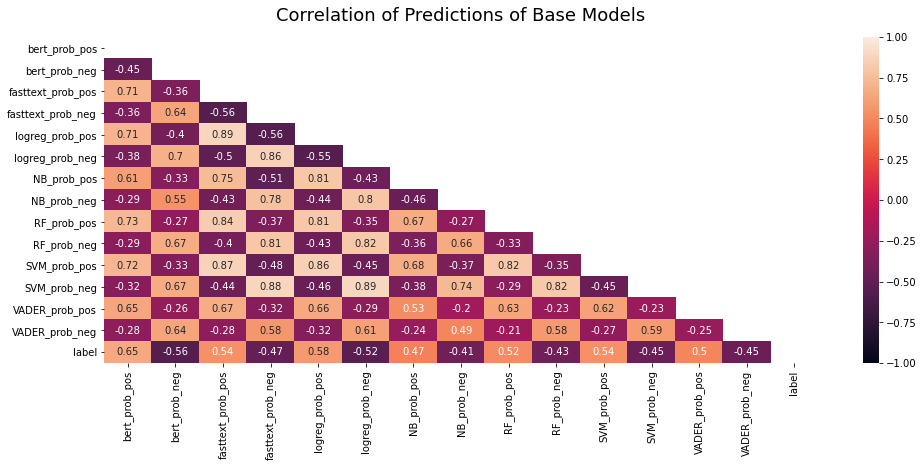

In [28]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(alldata.corr(), dtype=np.bool))
heatmap = sns.heatmap(alldata.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation of Predictions of Base Models', fontdict={'fontsize':18}, pad=16);

### Feature Importance

In [4]:
import pickle
final_model = pickle.load(open("saved_models/model_meta.pkl", "rb"))

In [24]:
# get importance
importance = final_model.coef_
classes = final_model.classes_
features = alldata.columns.tolist()[:-1]
features.append("intercept")
dictionary = {"Class":[],"Feature":[],"Score":[]}
# summarize feature importance
for j in classes:
    print(f"Class = {j}")
    print(final_model.intercept_[int(j)])
    coeff = list(importance[int(j)]) + [final_model.intercept_[int(j)]]
    print(f"Intercept: {final_model.intercept_[int(j)]}")
    for i,v in zip(features,coeff):
        dictionary["Class"].append(j)
        dictionary["Feature"].append(i)
        dictionary["Score"].append(v)
        print(f'Feature: {i}, Score: {v}')

    print()
feature_importance_dictionary = pd.DataFrame(dictionary)
feature_importance_dictionary.to_csv("meta_model_feature_impt.csv")

Class = -1.0
-1.0385781131565943
Intercept: -1.0385781131565943
Feature: bert_prob_pos, Score: 1.4484162544814014
Feature: bert_prob_neg, Score: -0.3828870974704295
Feature: fasttext_prob_pos, Score: 0.005087651624099029
Feature: fasttext_prob_neg, Score: 0.045877491672413576
Feature: logreg_prob_pos, Score: 0.44643598163543147
Feature: logreg_prob_neg, Score: -0.6547639603552157
Feature: NB_prob_pos, Score: 0.04481361666521396
Feature: NB_prob_neg, Score: -0.2712476640832236
Feature: RF_prob_pos, Score: 0.3900508321573805
Feature: RF_prob_neg, Score: 0.20107475778443543
Feature: SVM_prob_pos, Score: 0.21282636658563192
Feature: SVM_prob_neg, Score: -0.044797034053415966
Feature: VADER_prob_pos, Score: 0.8480988460468224
Feature: VADER_prob_neg, Score: -0.6061926752245609
Feature: intercept, Score: -1.0385781131565943

Class = 0.0
-0.5786979960734243
Intercept: -0.5786979960734243
Feature: bert_prob_pos, Score: -0.20082587279918257
Feature: bert_prob_neg, Score: 1.5694643161284632
Feat

In [22]:
pd.read_csv("meta_model_feature_impt.csv")

,Unnamed: 0,Class,Feature,Score
0,0,-1.0,bert_prob_pos,1.448416
1,1,-1.0,bert_prob_neg,-0.382887
2,2,-1.0,fasttext_prob_pos,0.005088
3,3,-1.0,fasttext_prob_neg,0.045877
4,4,-1.0,logreg_prob_pos,0.446436
5,5,-1.0,logreg_prob_neg,-0.654764
6,6,-1.0,NB_prob_pos,0.044814
7,7,-1.0,NB_prob_neg,-0.271248
8,8,-1.0,RF_prob_pos,0.390051
9,9,-1.0,RF_prob_neg,0.201075


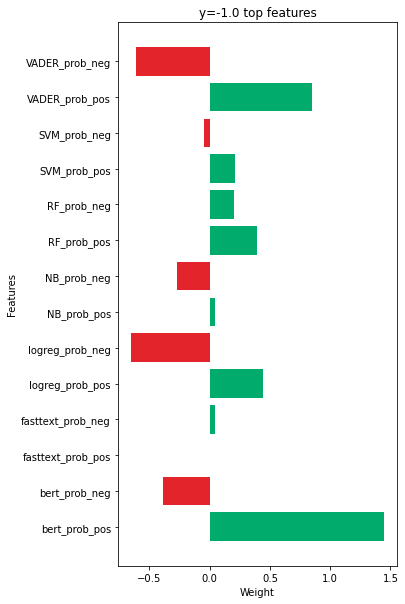

In [18]:
plt.figure(figsize=(5,10))
plt.subplot(1, 1, 1)

### CHANGE THIS PART ####
plt.barh(features, importance[-1], height=0.8,
         color=["#E3242B" if x<0 else "#00AB6B" for x in importance[-1]])
plt.title('Class = -1.0 top features')
plt.ylabel('Features')
plt.xlabel('Weight')
########################## 


plt.show()

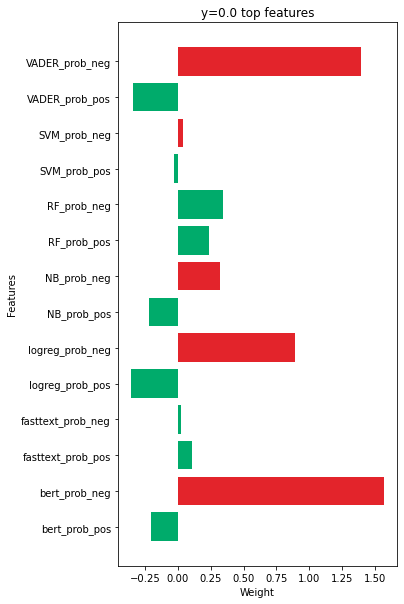

In [19]:
plt.figure(figsize=(5,10))
plt.subplot(1, 1, 1)

plt.barh(features, importance[0], height=0.8,
         color=["#E3242B" if x<0 else "#00AB6B" for x in importance[-1]])
plt.title('Class = 0.0 top features')
plt.ylabel('Features')
plt.xlabel('Weight')
 
plt.show()

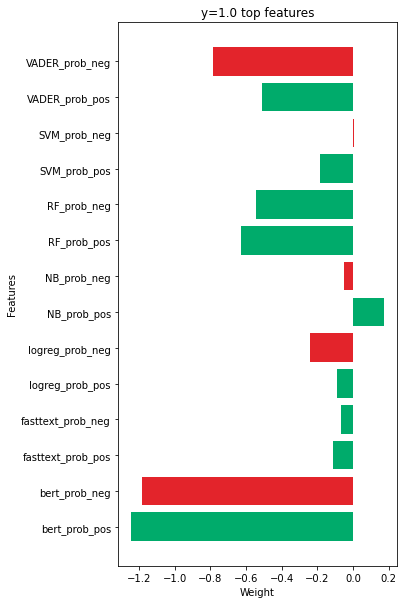

In [20]:
plt.figure(figsize=(5,10))
plt.subplot(1, 1, 1)

plt.barh(features, importance[1], height=0.8,
         color=["#E3242B" if x<0 else "#00AB6B" for x in importance[-1]])
plt.title('Class = 1.0 top features')
plt.ylabel('Features')
plt.xlabel('Weight')

plt.show()

### Train meta model after removing highly correlated terms from SVM & Log Reg base models

In [45]:
#remove svm n log reg
models = ["BERT","fasttext", "NB", "RF","VADER"]
meta_model_train = pd.DataFrame()
meta_model_test = pd.DataFrame()
meta_model_fold_1 = pd.DataFrame()
meta_model_fold_2 = pd.DataFrame()
meta_model_fold_3 = pd.DataFrame()
meta_model_fold_4 = pd.DataFrame()
meta_model_fold_5 = pd.DataFrame()

for model in models:
    fold1pred = pd.read_csv(f'fold_predictions/{model}/{model}_fold1.csv')
    meta_model_fold_1 = pd.concat([meta_model_fold_1,fold1pred], axis=1)
    
    fold2pred = pd.read_csv(f'fold_predictions/{model}/{model}_fold2.csv')
    meta_model_fold_2 = pd.concat([meta_model_fold_2,fold2pred], axis=1)

    fold3pred = pd.read_csv(f'fold_predictions/{model}/{model}_fold3.csv')
    meta_model_fold_3 = pd.concat([meta_model_fold_3,fold3pred], axis=1)

    fold4pred = pd.read_csv(f'fold_predictions/{model}/{model}_fold4.csv')
    meta_model_fold_4 = pd.concat([meta_model_fold_4,fold4pred], axis=1)

    fold5pred = pd.read_csv(f'fold_predictions/{model}/{model}_fold5.csv')    
    meta_model_fold_5 = pd.concat([meta_model_fold_5,fold5pred], axis=1)

    all_pred_train = pd.concat([fold1pred,fold2pred,fold3pred,fold4pred,fold5pred],axis = 0)
    meta_model_train = pd.concat([meta_model_train,all_pred_train], axis=1)
    
    testpred = pd.read_csv(f'fold_predictions/{model}/{model}_test.csv')
    meta_model_test = pd.concat([meta_model_test,testpred], axis=1)

    
data = [meta_model_fold_1,meta_model_fold_2,meta_model_fold_3,meta_model_fold_4,meta_model_fold_5,meta_model_train]
meta_model_train.head()


,bert_prob_pos,bert_prob_neg,fasttext_prob_pos,fasttext_prob_neg,NB_prob_pos,NB_prob_neg,RF_prob_pos,RF_prob_neg,VADER_prob_pos,VADER_prob_neg,label
0,0.967741,0.005076,0.563547,0.214631,0.833302,0.006866,0.950000,0.000000,0.592,0.000,1.0
1,0.976611,0.005581,0.573885,0.212415,0.823375,0.052906,0.940909,0.000000,1.000,0.000,1.0
2,0.142880,0.464640,0.368451,0.287994,0.548471,0.098711,0.711548,0.251786,0.145,0.150,0.0
3,0.199171,0.040443,0.311945,0.353513,0.043481,0.038845,0.319444,0.416667,0.154,0.203,1.0
4,0.972743,0.005263,0.431019,0.244249,0.867578,0.029769,0.825000,0.000000,0.765,0.000,1.0


In [46]:
model_name = "logreg"
model_fn = LogisticRegression
model_paramgrid = logreg_paramgrid
final_logreg_results = pd.DataFrame.from_records(models_grid_search(model_name,model_fn,model_paramgrid, data, meta_model_test))

model_name = "nb"
model_fn = MultinomialNB
model_paramgrid = nb_paramgrid
final_nb_results = pd.DataFrame.from_records(models_grid_search(model_name,model_fn,model_paramgrid, data, meta_model_test))

model_name = "svm"
model_fn = SVC
model_paramgrid = svm_paramgrid
final_svm_results = pd.DataFrame.from_records(models_grid_search(model_name,model_fn,model_paramgrid, data, meta_model_test))

model_name = "dummy"
model_fn = DummyClassifier
model_paramgrid = dummy_paramgrid
final_dummy_results = pd.DataFrame.from_records(models_grid_search(model_name,model_fn,model_paramgrid, data, meta_model_test))

a': 'scale', 'kernel': 'rbf', 'val_f1_weighted': 0.7935965280271114, 'val_f1_neg': 0.6859689613345026, 'val_f1_zero': 0.7554080278014704, 'val_f1_pos': 0.8492222107727813, 'val_accuracy': 0.7943784544362232, 'test_f1_weighted': 0.777613041695644, 'test_f1_neg': 0.6494845360824743, 'test_f1_zero': 0.710843373493976, 'test_f1_pos': 0.839160839160839, 'test_accuracy': 0.7741935483870968}
fold 0
fold 1
fold 2
fold 3
fold 4
{'model': 'svm', 'C': 0.5, 'class_weight': None, 'gamma': 'scale', 'kernel': 'sigmoid', 'val_f1_weighted': 0.4038581110370981, 'val_f1_neg': 0.4182223139872902, 'val_f1_zero': 0.29951776243914335, 'val_f1_pos': 0.47309326783094063, 'val_accuracy': 0.40119949092518814, 'test_f1_weighted': 0.48409506720680257, 'test_f1_neg': 0.3877995642701525, 'test_f1_zero': 0.44089456869009586, 'test_f1_pos': 0.5269922879177378, 'test_accuracy': 0.46838709677419355}
fold 0
fold 1
fold 2
fold 3
fold 4
{'model': 'svm', 'C': 0.5, 'class_weight': None, 'gamma': 'auto', 'kernel': 'poly', 'va

In [47]:
final_logreg_results = final_logreg_results.sort_values(by=["val_f1_weighted", "test_f1_weighted"], ascending=False)
final_nb_results = final_nb_results.sort_values(by=["val_f1_weighted", "test_f1_weighted"], ascending=False)
final_svm_results = final_svm_results.sort_values(by=["val_f1_weighted", "test_f1_weighted"], ascending=False)
final_dummy_results = final_dummy_results.sort_values(by=["val_f1_weighted", "test_f1_weighted"], ascending=False)

In [36]:
final_logreg_results.iloc[0,:]

model                 logreg
C                        0.1
class_weight        balanced
penalty                   l2
solver                 lbfgs
val_f1_weighted     0.800369
val_f1_neg          0.694595
val_f1_zero         0.766894
val_f1_pos          0.850548
val_accuracy        0.799425
test_f1_weighted    0.777963
test_f1_neg         0.691589
test_f1_zero        0.711111
test_f1_pos         0.829964
test_accuracy       0.772903
Name: 0, dtype: object

In [37]:
final_nb_results.iloc[0,:]

model                     nb
alpha                      0
val_f1_weighted     0.687895
val_f1_neg          0.653188
val_f1_zero         0.560106
val_f1_pos            0.7938
val_accuracy        0.704874
test_f1_weighted    0.721414
test_f1_neg         0.643678
test_f1_zero        0.542289
test_f1_pos         0.825462
test_accuracy       0.731613
Name: 0, dtype: object

In [38]:
final_svm_results.iloc[0,:]

model                    svm
C                        0.5
class_weight        balanced
gamma                  scale
kernel                   rbf
val_f1_weighted     0.796517
val_f1_neg          0.695457
val_f1_zero         0.759554
val_f1_pos          0.847995
val_accuracy        0.794998
test_f1_weighted    0.781584
test_f1_neg         0.714286
test_f1_zero        0.716049
test_f1_pos         0.828571
test_accuracy       0.776774
Name: 13, dtype: object

In [63]:
meta_model_train

,bert_prob_pos,bert_prob_neg,fasttext_prob_pos,fasttext_prob_neg,logreg_prob_pos,logreg_prob_neg,NB_prob_pos,NB_prob_neg,RF_prob_pos,RF_prob_neg,SVM_prob_pos,SVM_prob_neg,VADER_prob_pos,VADER_prob_neg,label
0,0.967741,0.005076,0.563547,0.214631,0.939938,0.004414,0.833302,0.006866,0.950000,0.000000,0.761402,0.014256,0.592,0.000,1.0
1,0.976611,0.005581,0.573885,0.212415,0.998430,0.000544,0.823375,0.052906,0.940909,0.000000,0.884794,0.020397,1.000,0.000,1.0
2,0.142880,0.464640,0.368451,0.287994,0.479545,0.127199,0.548471,0.098711,0.711548,0.251786,0.675172,0.081166,0.145,0.150,0.0
3,0.199171,0.040443,0.311945,0.353513,0.172376,0.229518,0.043481,0.038845,0.319444,0.416667,0.600380,0.136811,0.154,0.203,1.0
4,0.972743,0.005263,0.431019,0.244249,0.740021,0.065695,0.867578,0.029769,0.825000,0.000000,0.852314,0.023726,0.765,0.000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,0.730374,0.019244,0.435045,0.234340,0.759397,0.031726,0.551918,0.044922,0.356537,0.016667,0.610345,0.021992,0.000,0.000,1.0
500,0.027476,0.008017,0.284649,0.243095,0.151385,0.076345,0.286066,0.140698,0.040000,0.000000,0.218771,0.068482,0.000,0.000,0.0
501,0.977880,0.003583,0.491426,0.229751,0.919047,0.030341,0.925636,0.020181,0.875000,0.025000,0.865552,0.030570,0.574,0.000,1.0
502,0.976587,0.003633,0.554396,0.217331,0.973812,0.005844,0.999942,0.000003,0.943333,0.000000,0.885746,0.023931,0.442,0.000,1.0


In [66]:
alldata = pd.concat([meta_model_train,meta_model_test],axis=0)

# save model trained on all data
import pickle
best_param = {"C": final_logreg_results.iloc[0,:].to_dict()["C"],
"class_weight" : final_logreg_results.iloc[0,:].to_dict()["class_weight"] , "penalty" : final_logreg_results.iloc[0,:].to_dict()["penalty"], "solver" : final_logreg_results.iloc[0,:].to_dict()["solver"]}
final_model = LogisticRegression(**best_param)
final_model.fit(alldata.iloc[:,:-1], alldata.label)

model_pkl_filename = "saved_models/model_meta_2.pkl"
with open(model_pkl_filename, 'wb') as file:
    pickle.dump(final_model, file)

In [49]:
import pickle
final_model = pickle.load(open("saved_models/model_meta_2.pkl", "rb"))

In [50]:
# get importance
importance = final_model.coef_
classes = final_model.classes_
features = alldata.columns.tolist()[:-1]
features.append("intercept")
dictionary = {"Class":[],"Feature":[],"Score":[]}
# summarize feature importance
for j in classes:
    print(f"Class = {j}")
    print(final_model.intercept_[int(j)])
    coeff = list(importance[int(j)]) + [final_model.intercept_[int(j)]]
    print(f"Intercept: {final_model.intercept_[int(j)]}")
    for i,v in zip(features,coeff):
        dictionary["Class"].append(j)
        dictionary["Feature"].append(i)
        dictionary["Score"].append(v)
        print(f'Feature: {i}, Score: {v}')

    print()
feature_importance_dictionary = pd.DataFrame(dictionary)
feature_importance_dictionary.to_csv("meta_model_feature_impt1.csv")

Class = -1.0
-1.035526295252528
Intercept: -1.035526295252528
Feature: bert_prob_pos, Score: 1.5012064987311593
Feature: bert_prob_neg, Score: -0.45023708234952825
Feature: fasttext_prob_pos, Score: 0.20413444363826874
Feature: fasttext_prob_neg, Score: -0.08274757525493998
Feature: NB_prob_pos, Score: 0.21946134069826279
Feature: NB_prob_neg, Score: -0.5132679270920361
Feature: RF_prob_pos, Score: 0.5859176590039289
Feature: RF_prob_neg, Score: -0.012525634607078815
Feature: VADER_prob_pos, Score: 0.9103785549853952
Feature: VADER_prob_neg, Score: -0.6778712051300319
Feature: intercept, Score: -1.035526295252528

Class = 0.0
-0.5536170163152981
Intercept: -0.5536170163152981
Feature: bert_prob_pos, Score: -0.22083753910302123
Feature: bert_prob_neg, Score: 1.6648017457950852
Feature: fasttext_prob_pos, Score: -0.05527040785218305
Feature: fasttext_prob_neg, Score: 0.1988407316822858
Feature: NB_prob_pos, Score: -0.33748068457638636
Feature: NB_prob_neg, Score: 0.6475815941130005
Featu

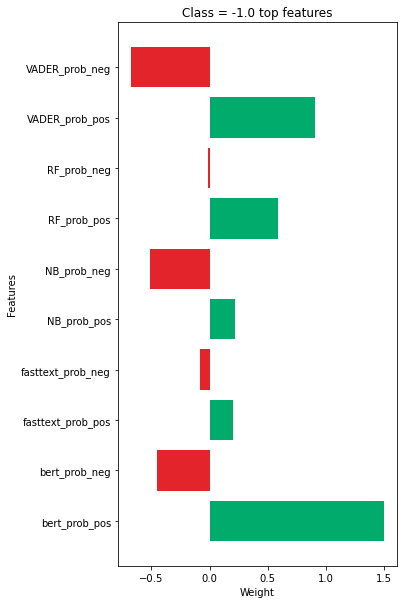

In [51]:
plt.figure(figsize=(5,10))
plt.subplot(1, 1, 1)

### CHANGE THIS PART ####
plt.barh(features[:-1], importance[-1], height=0.8,
         color=["#E3242B" if x<0 else "#00AB6B" for x in importance[-1]])
plt.title('Class = -1.0 top features')
plt.ylabel('Features')
plt.xlabel('Weight')
########################## 


plt.show()

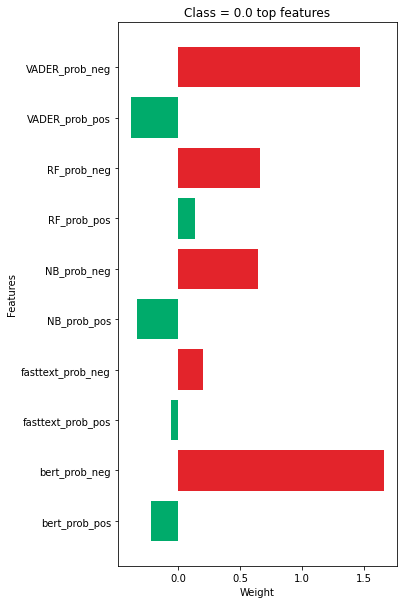

In [52]:
plt.figure(figsize=(5,10))
plt.subplot(1, 1, 1)

plt.barh(features[:-1], importance[0], height=0.8,
         color=["#E3242B" if x<0 else "#00AB6B" for x in importance[-1]])
plt.title('Class = 0.0 top features')
plt.ylabel('Features')
plt.xlabel('Weight')
 
plt.show()

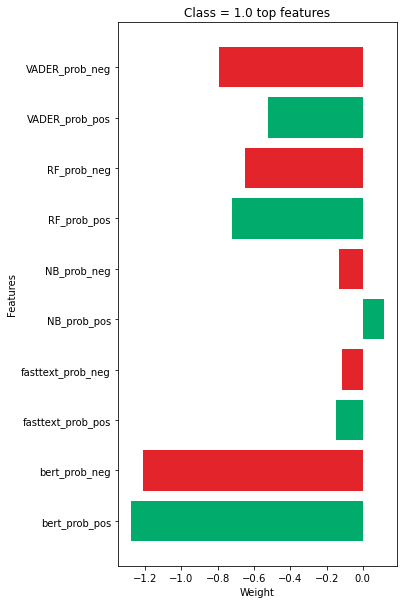

In [54]:
plt.figure(figsize=(5,10))
plt.subplot(1, 1, 1)

plt.barh(features[:-1], importance[1], height=0.8,
         color=["#E3242B" if x<0 else "#00AB6B" for x in importance[-1]])
plt.title('Class = 1.0 top features')
plt.ylabel('Features')
plt.xlabel('Weight')

plt.show()